# Network Operations Demo - Data Ingestion & Preparation
This project demonstrates how to build an automated machine-learning (ML) pipeline for predicting network outages based on network-device telemetry, also known as Network Operations (NetOps). The demo covers how to setup a real-time system for data ingestion, feature engineering, model training, deployment, and monitoring, on top of Iguazio's Data Science Platform. It uses the open source MLRun MLOps orchestration framework and Feature Store in combination with the open source Nuclio serverless engine as a runtime.

The demo consists of:
1. Building and testing features from three sources (device metadata, real-time device metrics, and real-time device labels) using the feature store.
2. Ingesting the data using batch (for testing) or real-time (for production).
3. Training and testing the model with data from the feature-store.
4. Deploying the model as part of a real-time feature engineering and inference pipeline.
5. Real-time model and metrics monitoring, drift detection.

**In this notebook:**
* [**Part 1: Create and configure an MLRun project**](#Part-1:-Create-and-configure-an-MLRun-project)
* [**Part 2: Define and test the feature engineering pipeline**](#Part-2:-Define-and-test-the-feature-engineering-pipelines)
* [**Part 3: Ingest the features data using batch or real-time**](#Part-3:-Ingest-the-features-data-using-batch-or-real-time)

In the next [**02-training-and-deployment**](./02-training-and-deployment.ipynb) notebook you can learn how to build automated pipelines that train, test, and deploy models using data from the feature store.

**Run the following ONCE to install the required packages, and then immediately restart the notebook kernel:**

In [ ]:
!pip install pytimeparse faker metrics-gen

## Part 1: Create and configure an MLRun project

In [2]:
# Import general utilities for the entire notebook
import os
import json
import yaml
import mlrun 
import mlrun.feature_store as fstore # MLRun's feature store

# Create or get the project
project = mlrun.get_or_create_project('network-operations', "./", user_project=True)

> 2022-03-21 15:37:18,805 [info] loaded project network-operations from MLRun DB


### Define the project parameters, artifacts, and functions
Throughout the project, there are files, configurations, streams, etc. that are shared with the different functions.  
Sharing is simplified by using the MLRun project parameters (`project.params`) or the artifacts, which are available to all the functions in the project.  

Define two stream paths for the network-device-metrics and network-device-labels, and a network-device static data KV table for the feature sets.  
You'll also log the parameters for the metrics generator (simulator), which are used by different functions in the project.

The functions/code used in the project are registered (using `set_function`) allowing reference to code/functions by name and CI/CD pipelines.

In [3]:
# Set the feature set names 
device_metrics_fs_name = 'device_metrics'
device_labels_fs_name = 'device_labels'
static_data_fs_name = 'static'
metric_configurations_path = "./src/metric_configurations.yaml"

# load the metrics configuration for local use and log it as an artifact for use by the functions
with open(metric_configurations_path, "r") as fp:
    metrics_configuration = yaml.safe_load(fp)
metrics_configuration_uri = project.log_artifact("metric_configurations", local_path=metric_configurations_path).uri

# Create iguazio v3io stream and device metrics push API endpoint
device_metrics_stream = f'v3io:///projects/{project.name}/streams/{device_metrics_fs_name}'
device_labels_stream = f'v3io:///projects/{project.name}/streams/{device_labels_fs_name}'

# Set the configuration and stream paths as a project parameters so they can be picked up by the functions
project.params = {
    'metrics_configuration_uri': metrics_configuration_uri,
    'device_metrics_stream': device_metrics_stream,
    'device_labels_stream': device_labels_stream,
}

# register the metrics generator function
project.set_function('src/generator.py', name='metrics-generator',  kind='nuclio',  
                     image='mlrun/mlrun', requirements=["pytimeparse", "faker", "metrics-gen"])

project.save()

In [4]:
# uncomment the line below to print the project spec
# print(project.to_yaml())

## Part 2: Define and test the feature engineering pipelines

This model uses two input datasets and one target labels dataset (y):
* Static data and metadata per device (location, model, etc.)
* Real-time metrics per device (CPU and memory usage, throughput, latency, etc.)
* Real-time Labels (indications for device failures/errors, etc.) 

Use the feature store to create three different **feature sets** (one per dataset) and apply various aggregations and transformations  

### Get the data sample (simulated) for developing the features
Use the `v3io_generator` simulator to generate fake device and metrics data with real-world behavior. The exact data schema and patterns are defined in the [**metrics configuration file**](./src/metric_configurations.yaml). It can be adjusted to simulate your specific features and time-series metrics.

The [**generator function**](./src/generator.py) is imported locally (for testing). Later in the notebook you'll see how it can also be deployed as a real-time Nuclio function that continuously sends real-time metrics and labels over streams (for testing real-time ingestion/processing).

Use the generator and retrieve sample data (Static devices dataset, Real-time metrics, Real-time Labels) for developing and testing our features.

In [5]:
from src.generator import get_sample, config_to_static_mappings

with open(metric_configurations_path, "r") as fp:
    metrics_configuration = yaml.safe_load(fp)

metrics_df, labels_df, static_df = get_sample(metrics_configuration, project=project)

### Feature Set 1 - Static Network Devices data/metadata 
This feature set holds all the static network-device data. As such, it will be represented and ingested as a table.  
Since such static data usually holds a lot of categorical properties about the device, use a `one hot encoder` to encode the categorical features to a supported format, and then save this dataset result to a No-Sql (Key Value) table.  

After defining the feature set, plot its computational graph so you can easily review it in the notebook, preview it to test the wanted results, and deploy it.

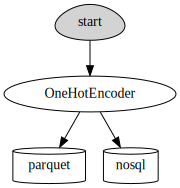

In [6]:
from mlrun.feature_store.steps import OneHotEncoder

# Define the feature set
static_fs = fstore.FeatureSet('static', 
                              entities=['device'], 
                              description='Static data for the devices')

# Append the one hot encoder to the feature set's processing graph, use values from the configuration
static_fs.graph.to(OneHotEncoder(mapping=config_to_static_mappings(metrics_configuration)))

# Set the default targets for the feature set (parquet & no-sql)
static_fs.set_targets()

# Show a plot of the feature set's processing graph
static_fs.plot(with_targets=True)

In [7]:
# Preview the feature sets computation results
# (this is how the data will be finally saved to the feature store)
# * The preview also serves to infer the schema of the feature set 
# * that could be saved later with the feature set.
fstore.preview(static_fs, static_df).head()

,models_0,models_1,models_2,models_3,models_4,models_5,models_6,models_7,models_8,models_9,country_A,country_B,country_C,country_D,country_E,country_F,country_G
device,,,,,,,,,,,,,,,,,
0517655866735,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
2371451183019,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4541123052929,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8664701497798,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
0109077675664,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [8]:
# Save the feature set with the inferred schema to the feature store DB
static_fs.save()

### Feature Set 2 - Network Device Metrics
The device metrics feature set holds the network-device telemetry, including:
- CPU Utilization
- Throughput
- Packet Loss
- Latency

This feature set represents ingestion of real-time timeseries data via an incoming data stream. This code defines rolling aggregations of `mean`, `min`, `max` on top of `1 hour` and `6 hours` windows.


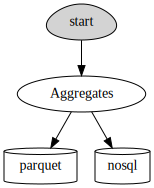

In [9]:
# Define the feature set
device_metrics_set = fstore.FeatureSet("device_metrics", 
                                       entities=["device"], 
                                       timestamp_key='timestamp',
                                       description="Collected network device metrics")

# Add aggregations to all metrics
metrics = ['cpu_utilization', 'throughput', 'latency', 'packet_loss']
for metric in metrics:
    # add a specific metric aggregation
    device_metrics_set.add_aggregation(name=metric, 
                                       column=metric, 
                                       operations=['avg', 'min', 'max'], 
                                       windows=['1h', '6h'], period='10m')

# Add the default targets (Parquet / No-Sql) and plot the data pipeline (graph)
device_metrics_set.set_targets()
device_metrics_set.plot(with_targets=True)

In [10]:
# Preview and test the calculated features before the deployment 
fstore.preview(device_metrics_set, metrics_df).head()

,cpu_utilization_max_1h,cpu_utilization_max_6h,cpu_utilization_min_1h,cpu_utilization_min_6h,cpu_utilization_avg_1h,cpu_utilization_avg_6h,throughput_max_1h,throughput_max_6h,throughput_min_1h,throughput_min_6h,...,packet_loss_min_1h,packet_loss_min_6h,packet_loss_avg_1h,packet_loss_avg_6h,cpu_utilization,latency,packet_loss,throughput,timestamp,index
device,,,,,,,,,,,,,,,,,,,,,
0517655866735,61.203037,61.203037,61.203037,61.203037,61.203037,61.203037,262.130632,262.130632,262.130632,262.130632,...,0.0,0.0,0.0,0.0,61.203037,0.0,0.0,262.130632,2022-03-20 15:37:34,0
2371451183019,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000,...,50.0,50.0,50.0,50.0,100.000000,100.0,50.0,0.000000,2022-03-20 15:37:34,1
4541123052929,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000,...,50.0,50.0,50.0,50.0,100.000000,100.0,50.0,0.000000,2022-03-20 15:37:34,2
8664701497798,66.301653,66.301653,66.301653,66.301653,66.301653,66.301653,242.640984,242.640984,242.640984,242.640984,...,0.0,0.0,0.0,0.0,66.301653,0.0,0.0,242.640984,2022-03-20 15:37:34,3
0109077675664,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000,...,50.0,50.0,50.0,50.0,100.000000,100.0,50.0,0.000000,2022-03-20 15:37:34,4


In [11]:
# Save the device metrics feature set with the inferred schema
device_metrics_set.save()

### Feature Set 3 - Network Device Labels
This feature set represents incoming failure labels for our devices.  The labels are ingested through their own stream to simulate their arrival through a different process and apply the asof merging with the related metrics through the feature store.


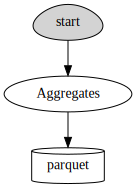

In [12]:
device_labels_set = fstore.FeatureSet("device_labels", 
                                       entities=[fstore.Entity("device")], 
                                       timestamp_key='timestamp',
                                       description="Collected network device labels")

# Add aggregations
metrics = ['cpu_utilization']
for metric in metrics:
    device_labels_set.add_aggregation(name=metric, 
                                       column=metric, 
                                       operations=['max'], 
                                       windows=['1h'], period='10m')

# specify only Parquet (offline) target since it's not used for real-time
device_labels_set.set_targets(['parquet'], with_defaults=False)
device_labels_set.plot(with_targets=True)

In [13]:
# Preview and test the `device_labels_set` features
fstore.preview(device_labels_set, labels_df).head()

Converting input from bool to <class 'numpy.uint8'> for compatibility.


,cpu_utilization_max_1h,cpu_utilization_is_error,latency_is_error,packet_loss_is_error,throughput_is_error,is_error,timestamp,index
device,,,,,,,,
0517655866735,NaN,False,False,False,False,False,2022-03-20 15:37:34,0
2371451183019,NaN,False,False,False,False,False,2022-03-20 15:37:34,1
4541123052929,NaN,True,True,True,True,True,2022-03-20 15:37:34,2
8664701497798,NaN,False,False,False,False,False,2022-03-20 15:37:34,3
0109077675664,NaN,False,False,False,False,False,2022-03-20 15:37:34,4


In [14]:
device_labels_set.save()

<br>

## Part 3: Ingest the features data using batch or real-time

To use the features in training or serving the data must be ingested into the feature store, there are three ways to ingest data:
1. Direct ingestion - ingest the data directly from the client/notebook (interactively) 
2. Batch/scheduled ingestion - create a service/job whithat that ingests data from the source (e.g. file, DB, ..)
3. Real-time/Streaming ingestion - create an online service that accepts real-time events (from a stream, http, etc.) and push them into the feature store

Direct and batch ingestion are achieved using the `ingest()` method, while real-time ingestion is done using the `deploy_ingestion_service()` method. Both methods are demonstrated in the following sections. The direct ingestion is great for development and testing while the real-time ingestion is mainly used in production.

### Direct/batch ingestion of the sample data 

To run training or test the serving you need to ingest and transform the input datasets and store the results in the feature store. The simplest way is to use the `ingest()` method and specify the feature-set and the source (Dataframe, file, etc.).

You can specify the desired target if you want to overwrite the default behavior. For example, set `targets=[ParquetTarget()]` to specify that the data will only be written to parquet files and will not be written to the NoSQL DB (meaning you cannot run real-time serving).

The `ingest()` method has many other args/options, see the documentation for details.

**Once the data is ingested you can run next [02-training-and-deployment](./02-training-and-deployment.ipynb) notebook**

In [15]:
from mlrun.datastore.targets import ParquetTarget

# ingest the static device data
fstore.ingest(static_fs, static_df)

# ingest the device metrics
fstore.ingest(device_metrics_set, metrics_df)

# ingest the labels
_ = fstore.ingest(device_labels_set, labels_df, targets=[ParquetTarget()])

Converting input from bool to <class 'numpy.uint8'> for compatibility.


<br>

### Real-time ingestion

In production the data arrives in real-time via a stream, the ingestion service uses real-time Nuclio functions that listen on the event stream or HTTP endpoint and ingest the data while running the set of real-time transformations and aggregations.

To simulate the real-time streams, create a real-time generator function that generates semi-random data and writes it into streams. The feature ingestion services reads from those streams, transforms the data and writes the results in parallel into offline (parquet files) and online (NoSQL DB) data targets.

#### Create the real-time generator function
Deploy the [**metrics generator function**](src/generator.py) that generates the following simulated data: 
- Static table with all the network devices, their model, and manufacturing country
- Metrics stream with telemetry data
- Labels the streams with labels for the device status

The description and statistics for the simulated data are defined in the [**metrics configuration file**](./src/metric_configurations.yaml).

The generator function is deployed as a Nuclio function on top of the Kubernetes cluster and is called every one minute as defined via the cron trigger to produce new data and push it to the relevant streams.  Later on, MLRun's feature store ingestion functions listen to these streams and tables and ingest the data to the feature store.  

In [16]:
from mlrun import code_to_function, mount_v3io
import nuclio

# Configure and deploy the metrics generator function
fn = project.get_function('metrics-generator')

# Add a cron trigger to run the function every set interval
fn.add_trigger('cron', nuclio.triggers.CronTrigger(interval='1m'))

# Deploy the function on top of our kubernetes cluster
fn.deploy()

> 2022-03-21 15:37:33,545 [info] Starting remote function deploy
2022-03-21 15:37:33  (info) Deploying function
2022-03-21 15:37:33  (info) Building
2022-03-21 15:37:34  (info) Staging files and preparing base images
2022-03-21 15:37:34  (info) Building processor image
2022-03-21 15:37:37  (info) Build complete
2022-03-21 15:37:45  (info) Function deploy complete
> 2022-03-21 15:37:45,980 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-network-operations-orz-metrics-generator.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['network-operations-orz-metrics-generator-network-operations-orz.default-tenant.app.app-lab-testing.iguazio-cd0.com/']}


'http://network-operations-orz-metrics-generator-network-operations-orz.default-tenant.app.app-lab-testing.iguazio-cd0.com/'

#### Deploy the device metrics feature set ingestion endpoint

Next, deploy the device metrics feature set processing pipeline over real-time serverless (Nuclio) function. Specify the source as a `StreamSource` with the path to the `device_metrics_stream`, and you can specify which fields are used to determine the index and timestamp key.

In [17]:
# Define the V3IO Stream Source from which the events data (in json format) are read.
# we will define which fields in the json struct are used as `key` and `time` fields.
source = mlrun.datastore.sources.StreamSource(path=device_metrics_stream , key_field='device', time_field='timestamp')

# Deploy the transactions feature set's ingestion service using the feature set
# and all the defined resources above.
device_metrics_set_endpoint = fstore.deploy_ingestion_service(
    featureset=device_metrics_set, source=source)

> 2022-03-21 15:37:46,273 [info] Starting remote function deploy
2022-03-21 15:37:46  (info) Deploying function
2022-03-21 15:37:46  (info) Building
2022-03-21 15:37:46  (info) Staging files and preparing base images
2022-03-21 15:37:46  (info) Building processor image
2022-03-21 15:37:48  (info) Build complete
2022-03-21 15:37:53  (info) Function deploy complete
> 2022-03-21 15:37:53,983 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-network-operations-orz-device-metrics-ingest.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['network-operations-orz-device-metrics-ingest-network-o-ab8w1cne.default-tenant.app.app-lab-testing.iguazio-cd0.com/']}


#### Deploy device labels endpoint
Deploy the device labels feature set processing pipeline over real-time serverless (Nuclio) function: specify the source as a `StreamSource` with the path to the `device_labels_stream`, and you can specify which fields are used to determine the index and timestamp key.

In [18]:
# Define the V3IO Stream Source from which the events data (in json format) are read.
source = mlrun.datastore.sources.StreamSource(path=device_labels_stream , key_field='device', time_field='timestamp')

# Deploy the transactions feature set's ingestion service using the feature set
device_labels_set_endpoint = fstore.deploy_ingestion_service(
    featureset=device_labels_set, source=source)

> 2022-03-21 15:37:54,148 [info] Starting remote function deploy
2022-03-21 15:37:54  (info) Deploying function
2022-03-21 15:37:54  (info) Building
2022-03-21 15:37:54  (info) Staging files and preparing base images
2022-03-21 15:37:54  (info) Building processor image
2022-03-21 15:37:55  (info) Build complete
2022-03-21 15:38:01  (info) Function deploy complete
> 2022-03-21 15:38:01,789 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-network-operations-orz-device-labels-ingest.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['network-operations-orz-device-labels-ingest-network-op-o9h6w77y.default-tenant.app.app-lab-testing.iguazio-cd0.com/']}


<br>

**Done! now we can move to the next [02-training-and-deployment](./02-training-and-deployment.ipynb) notebook**